<a href="https://colab.research.google.com/github/Lawrence-Krukrubo/fraud_analyst_assignment/blob/main/fraud_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First let's mount Google Drive so we can navigate the folders as needed
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Let's import some much needed libraries...**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import xlrd
print('done!')

done!


**Let's change our Directory to the Fraud directory containing our data**

In [3]:
FRAUD_DIR = '/content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment'
os.chdir(FRAUD_DIR)
print(f'Current Dir: {os.getcwd()}')

Current Dir: /content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment


In [4]:
# Let's see the contents of the CWD
os.listdir()

['Fraud_sample_data.xlsx', 'questionsAndPoints.gdoc', 'fraud_analysis.ipynb']

The dataset contains 3 sheets, the first at index 0 is the data dictionary, the remaining two at indexes 1 and 2 are June and July transactions respectively.<br>**Let's read out the data dictionary to guide us**

In [5]:
pd.set_option('max_colwidth', None)  # So that we see full field descriptions
data_dict = pd.read_excel('Fraud_sample_data.xlsx', sheet_name=0)
data_dict

,Field name,Field description
0,merchant_id,Randomly generated identifier to represent a merchant
1,merchant_industry,Industry in which the merchant operates
2,merchant_category,Business category of the merchant
3,merchant_country,The country in which the merchant is based
4,currency,The local currency the transcation was processed in
5,transaction_week_start_date,Week in which the transaction occured
6,channel,The payment method for the transaction
7,transaction_count,The number of transactions for the day
8,transaction_volume_usd,The total value of the transactions converted to USD
9,fraud_count,The number of transactions which were reported as fraudulent for the day


**Now, let's read in the respective data for the months of June and July...**

In [6]:
# For June transactions
june_df = pd.read_excel('Fraud_sample_data.xlsx', sheet_name=1)

# For July transactions
july_df = pd.read_excel('Fraud_sample_data.xlsx', sheet_name=2)
print('done!')

done!


In [7]:
# Let's see the june and july data shapes
print(f'June data shape: {june_df.shape}\nJuly data shape: {july_df.shape}\n')

June data shape: (8609, 13)
July data shape: (8809, 13)



We can see that July transactions have more observations than June, precisely 200 more.<br>But they both have the same dimensions of 13 features. Let's see the head and tail of June.

In [8]:
june_df.head()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,NaN,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,NaN,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,NaN,0,1
3,11,SERVICES-PROFESSIONAL,Other,Nigeria,NGN,2021-06-07,card,5,212.335958,0,NaN,0,5
4,15,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-06-07,card,8,550.131234,0,NaN,0,8


In [9]:
june_df.tail()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
8604,8605,INTERNET,Utilities,Nigeria,NGN,2021-06-28,card,1,2.624672,0,NaN,0,1
8605,8606,GOODS-DIGITAL,Digital Services,Nigeria,NGN,2021-06-28,card,1,0.262467,0,NaN,0,1
8606,8607,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-06-28,card,3,15.748031,0,NaN,0,3
8607,8608,EVENTS,Travel & Hospitality,Nigeria,NGN,2021-06-28,card,2,0.656168,0,NaN,0,2
8608,8609,INTERNET,Utilities,Nigeria,NGN,2021-06-28,card,1,0.262467,0,NaN,0,1


**Let's see the head and tail of July**

In [10]:
july_df.head()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-07-05,card,3,54.173228,0,NaN,0,3
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-07-05,card,4,486.712598,0,NaN,0,4
2,8,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-07-05,card,3,118.110236,0,NaN,0,0
3,9,SERVICES-PROFESSIONAL,Other,Nigeria,NGN,2021-07-05,card,4,151.968504,0,NaN,0,3
4,12,SERVICES-DIGITAL,Financial Services,Nigeria,NGN,2021-07-05,card,15,659.055118,0,NaN,0,12


In [11]:
july_df.tail()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
8804,8805,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-07-26,card,1,0.524934,0,NaN,0,1
8805,8806,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-07-26,card,1,0.259843,0,NaN,0,1
8806,8807,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-07-26,card,5,2.624672,0,NaN,0,5
8807,8808,RESTAURANTS,Travel & Hospitality,Nigeria,NGN,2021-07-26,card,2,1.049869,0,NaN,0,1
8808,8809,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-07-26,card,1,1.312336,0,NaN,0,1


# Descriptive EDA (DA1):

**Descriptive analytics (DA1):** <br>is a preliminary stage of data processing that creates a summary of historical data to yield useful information and possibly prepare the data for further analysis. It is used largely to answer the question **[‘What happened?’]**. Querying, reporting, data aggregation, data mining and data visualization may be applied to yield more insight.

**Geo-Location-based DA1:**<br>
1. What is the distribution of transactions across the 3 countries?
2. What is the Fraud/Transactions Ratio per country?

**Fraud-related DA1:**<br>
3. What is the Max and Mean fraud value for June and July?
4. What is the total fraud recorded for June and July?
5. Drilling into OTP-Fraud, what’s the Max and Mean values monthly?
6. What is the Max and Mean dollar cost of fraud for June and July?
7. What is the ratio of fraudulent/non-fraudulent transactions monthly

Answering these questions, give us a top-level vision of the state of the transactions and fraudulent activities and their impacts across the 3 countries the business operates in.


### 1. Confirming the data-types

In [12]:
june_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8609 entries, 0 to 8608
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   merchant_id                  8609 non-null   int64         
 1   merchant_industry            8609 non-null   object        
 2   merchant_category            8609 non-null   object        
 3   merchant_country             8609 non-null   object        
 4   currency                     8609 non-null   object        
 5   transaction_week_start_date  8609 non-null   datetime64[ns]
 6   channel                      8609 non-null   object        
 7   transaction_count            8609 non-null   int64         
 8   transaction_volume_usd       8609 non-null   float64       
 9   fraud_count                  8609 non-null   int64         
 10  fraud_volume_usd             61 non-null     float64       
 11  otp_fraud                    8609 non-null 

In [13]:
july_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8809 entries, 0 to 8808
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   merchant_id                  8809 non-null   int64         
 1   merchant_industry            8809 non-null   object        
 2   merchant_category            8809 non-null   object        
 3   merchant_country             8809 non-null   object        
 4   currency                     8809 non-null   object        
 5   transaction_week_start_date  8809 non-null   datetime64[ns]
 6   channel                      8809 non-null   object        
 7   transaction_count            8809 non-null   int64         
 8   transaction_volume_usd       8809 non-null   float64       
 9   fraud_count                  8809 non-null   int64         
 10  fraud_volume_usd             51 non-null     float64       
 11  otp_fraud                    8809 non-null 

So, we can see the data-types for the months of June and July. They conform to the expected data-types. All columns that should be numeric are and all that should be categorical or object are too.

### 2. Checking the Descriptive Statistics of the data:

In [14]:
# For June numeric features

june_df.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_id,8609.0,4304.018469,2485.466539,1.000000,2153.000000,4304.000000,6456.000000,8.609000e+03
transaction_count,8609.0,485.230573,8253.372691,1.000000,1.000000,3.000000,11.000000,2.758660e+05
transaction_volume_usd,8609.0,7000.276672,73800.550994,0.000026,9.186352,43.307087,236.220472,2.396408e+06
fraud_count,8609.0,0.108375,3.175327,0.000000,0.000000,0.000000,0.000000,1.700000e+02
fraud_volume_usd,61.0,1858.473460,4641.861843,0.524934,26.246719,91.338583,539.212598,2.017848e+04
otp_fraud,8609.0,0.009293,0.265166,0.000000,0.000000,0.000000,0.000000,1.700000e+01
otp_all_transactions,8609.0,81.615402,589.620590,0.000000,1.000000,2.000000,9.000000,1.222300e+04


In [15]:
# For July numeric features

july_df.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_id,8809.0,4404.009536,2543.190394,1.000000,2201.000000,4405.000000,6607.000000,8.809000e+03
transaction_count,8809.0,452.862300,7493.961064,1.000000,1.000000,3.000000,12.000000,2.321840e+05
transaction_volume_usd,8809.0,6456.769974,65039.969627,0.000026,9.186352,43.307087,237.270341,2.444412e+06
fraud_count,8809.0,0.044386,1.144114,0.000000,0.000000,0.000000,0.000000,6.200000e+01
fraud_volume_usd,51.0,1261.399492,2420.278420,0.262467,21.900997,132.545932,1040.682415,9.956378e+03
otp_fraud,8809.0,0.006925,0.187173,0.000000,0.000000,0.000000,0.000000,1.000000e+01
otp_all_transactions,8809.0,156.574753,3732.010232,0.000000,1.000000,2.000000,9.000000,2.015910e+05


We can see that there's complete count for all numeric columns except `fraud_volume_usd` which has a count of 61 in June and 51 in July. This depicts missing values present. We can also observe the following...
1. Max `fraud_count` per day in June is 170, while in July is 62
2. Mean `fraud_volume_usd` in June is 1858, while in July is 1261. Note that these figures are large because we have only 61 and 51 data represented now, since the rest are NaN values in this column.
3. Max `fraud_volume_usd` in any given day in June is 20178, while July is 9956
4. For `otp_fraud`, the Max a day in June is 17, while July Max is 10
5. While June has Max `otp_all_transactions` a day as 12223 and July as 201591

**Let's see the count of unique merchants that did transactions for June and July**

In [16]:
june_merchant_count = june_df.merchant_id.nunique()
july_merchant_count = july_df.merchant_id.nunique()

print(f'Total Merchants for June: {june_merchant_count}\nTotal Merchants for July: {july_merchant_count}')

Total Merchants for June: 3866
Total Merchants for July: 3895


**So we had slightly more (about 29) merchants in July than June.**

In [17]:
# For June categoric features

june_df.describe(include='object').T

,count,unique,top,freq
merchant_industry,8609,63,GOODS-PHYSICAL,1358
merchant_category,8609,11,Digital Services,1601
merchant_country,8609,3,Nigeria,8577
currency,8609,4,NGN,8540
channel,8609,1,card,8609


In [18]:
# For July categoric features

july_df.describe(include='object').T

,count,unique,top,freq
merchant_industry,8809,62,GOODS-PHYSICAL,1356
merchant_category,8809,11,Other,1473
merchant_country,8809,3,Nigeria,8784
currency,8809,4,NGN,8744
channel,8809,1,card,8809


From the categorical features summary, we can see that...
1. There are 63 unique merchant industries in June and 62 in July,
2. There are 11 distinct merchant categories, and 3 distinct merchant countries, 4 distinct currencies and 1 distinct channel for both months, which is the `card` channel.

### 3. Checking for missing values:

In [19]:
june_df.isna().any()

merchant_id                    False
merchant_industry              False
merchant_category              False
merchant_country               False
currency                       False
transaction_week_start_date    False
channel                        False
transaction_count              False
transaction_volume_usd         False
fraud_count                    False
fraud_volume_usd                True
otp_fraud                      False
otp_all_transactions           False
dtype: bool

In [20]:
july_df.isna().any()

merchant_id                    False
merchant_industry              False
merchant_category              False
merchant_country               False
currency                       False
transaction_week_start_date    False
channel                        False
transaction_count              False
transaction_volume_usd         False
fraud_count                    False
fraud_volume_usd                True
otp_fraud                      False
otp_all_transactions           False
dtype: bool

We can see that for both June and July, only `fraud_volume_usd` has missing values. On further investigation, it is clear to see why. This is so because when `fraud_count` is 0, then `fraud_volume_usd` defaults to NaN.<br>Since we know that `fraud_volume_usd` should be 0, when `fraud_count` is 0, let's override this accordingly.

In [21]:
# replacing all missing values in the fraud_volume_usd col to 0

june_df.fraud_volume_usd.fillna(0, inplace=True)
july_df.fraud_volume_usd.fillna(0, inplace=True)
print('done!')

done!


**Let's confirm that all missing values have been replaced**

In [22]:
june_df.isna().any()

merchant_id                    False
merchant_industry              False
merchant_category              False
merchant_country               False
currency                       False
transaction_week_start_date    False
channel                        False
transaction_count              False
transaction_volume_usd         False
fraud_count                    False
fraud_volume_usd               False
otp_fraud                      False
otp_all_transactions           False
dtype: bool

In [23]:
july_df.isna().any()

merchant_id                    False
merchant_industry              False
merchant_category              False
merchant_country               False
currency                       False
transaction_week_start_date    False
channel                        False
transaction_count              False
transaction_volume_usd         False
fraud_count                    False
fraud_volume_usd               False
otp_fraud                      False
otp_all_transactions           False
dtype: bool

### 4. Some basic visualization of June and July transactions:

**Let's explore the distribution of transactions across the distinct countries for June and July**

In [24]:
def compare_pie_chart(sup_title, titles, s1, s2, size, colours):
    """Pie chart to compare values for June and July
    
    @param suptitle: Str, summary title of the plot
    @param titles: List of string sub-titles per plot
    @param s1: first series object
    @param s2: second series object
    @param size: A tuple of figure size
    @param colours: A List of colors for the piecharts
    """
    plt.figure(figsize=size)
    sns.set(font_scale=1.2)
    sns.set_style('ticks')
    plt.suptitle(sup_title, y=1.05)

    # For the first plot
    plt.subplot(121)
    plt.pie(s1, 
       autopct='%1.1f%%',
       colors=colours,
       startangle=90,
       shadow=True,
       pctdistance=1.06)
    plt.title(titles[0], y=1.05)
    plt.axis('equal')
    plt.legend(labels=s1.index, loc='upper right')

    # For the second plot
    plt.subplot(122)
    plt.pie(s2, 
       autopct='%1.1f%%',
       colors=colours,
       startangle=90,
       shadow=True,
       pctdistance=1.06)
    plt.title(titles[1], y=1.05)
    plt.axis('equal')
    plt.legend(labels=s2.index, loc='upper right')

    plt.show()

In [25]:
countries = list(june_df.merchant_country.unique())

def get_country_transactions(countries, df1, df2):
    """Function to get total transactions per country

    @param countries: list of string country names
    @param df1 and df2: June and July Dataframes
    """

    s1_list = []
    s2_list = []

    for country in countries:
        temp1 = df1[df1['merchant_country'] == country]
        s1_list.append(sum(temp1['transaction_count']))

        temp2 = df2[df2['merchant_country'] == country]
        s2_list.append(sum(temp2['transaction_count']))
    
    s1 = pd.Series(s1_list, index=countries)
    s2 = pd.Series(s2_list, index=countries)

    return s1, s2 

In [26]:
june_country_split, july_country_split = get_country_transactions(countries, june_df, july_df)

In [27]:
june_country_split

Nigeria         4177313
Ghana                35
South Africa          2
dtype: int64

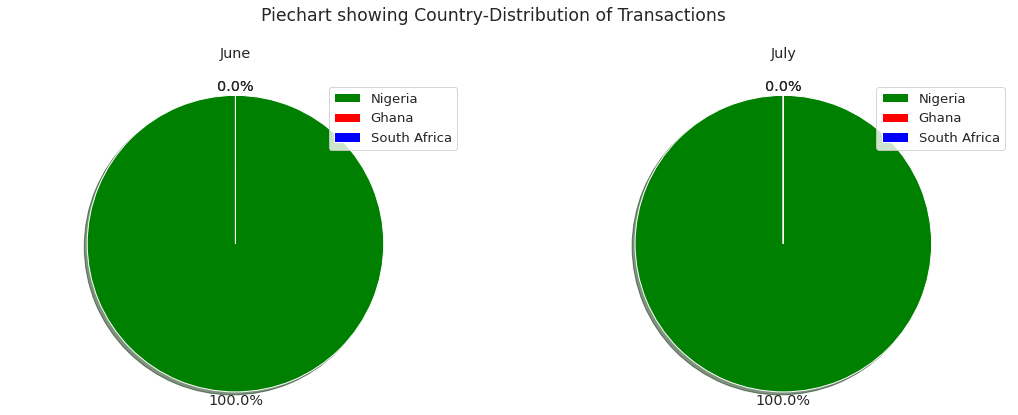

In [28]:
# Let's define some variables

sup_title = 'Piechart showing Country-Distribution of Transactions'
titles = ['June', 'July']
s1 = june_country_split
s2 = july_country_split
size = (18, 6)
colours = ['green','red','blue']

compare_pie_chart(sup_title, titles, s1, s2, size, colours)

In [29]:
ng_june_t = june_country_split['Nigeria']
ng_july_t = july_country_split['Nigeria']
gh_june_t = june_country_split['Ghana']
gh_july_t = july_country_split['Ghana']
sa_june_t = june_country_split['South Africa']
sa_july_t = july_country_split['South Africa']

print(f'In June, the country-transactions-count is:\nNigeria: {ng_june_t}\nGhana: {gh_june_t}\nSA: {sa_june_t}\n')
print()
print(f'In July, the country-transactions-count is:\nNigeria: {ng_july_t}\nGhana: {gh_july_t}\nSA: {sa_july_t}\n')

In June, the country-transactions-count is:
Nigeria: 4177313
Ghana: 35
SA: 2


In July, the country-transactions-count is:
Nigeria: 3989230
Ghana: 32
SA: 2



We can see from the three countries represented in the data, that Nigeria alone has over 99.7% of all transactions. Thus, I can assume that more fraudulent activities occur within Nigeria.<br>
* SA has only 2 transactions per month
* Ghana has just about 35 per month
* Nigeria has about 4 million transactions monthly.

**But before I jump to conclusions, let's see the percentage distribution of total fraud per country transactions.**

In [30]:
def get_country_fraud_pct_df(df):
    country_ratio = []

    for country in countries:
        country_df = df[df['merchant_country'] == country]
        ratio = sum(country_df.fraud_count) / sum(country_df.transaction_count)
        pct = ratio * 100
        country_ratio.append(pct)

    final_df = pd.DataFrame(country_ratio, index=countries, columns=['Pct'])

    return final_df

In [31]:
june_country_fraud_ratio = get_country_fraud_pct_df(june_df)
july_country_fraud_ratio = get_country_fraud_pct_df(july_df)

june_country_fraud_ratio

,Pct
Nigeria,0.022335
Ghana,0.000000
South Africa,0.000000


In [32]:
def compare_bar_chart(df1, df2, colours, col):
    plt.figure(figsize=size)
    sns.set(font_scale=1.2)
    sns.set_style('ticks')
    plt.suptitle(sup_title, y=1.05)

    # For June
    plt.subplot(121)
    plt.bar(x=df1.index, height=df1[col], data=df1, color= colours, width=0.5)
    plt.title(titles[0])
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    for x,y in zip(df1.index, df1[col]):
        label = round(y,2)  #  could also be written as:-   "{:.2f}".format(y)
        
        plt.annotate(label, # this is the text
                    (x,y), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,4), # distance from text to points (x,y)
                    ha='center',) # horizontal alignment can be left, right or center


    # For July
    plt.subplot(122)
    plt.bar(x=df2.index, height=df2[col], data=df2, color= colours, width=0.5)
    plt.title(titles[1])
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    for x,y in zip(df2.index, df2[col]):
        label = round(y,2) 
        plt.annotate(label,
                    (x,y), 
                    textcoords="offset points", 
                    xytext=(0,4),
                    ha='center',) 
    
    plt.show()

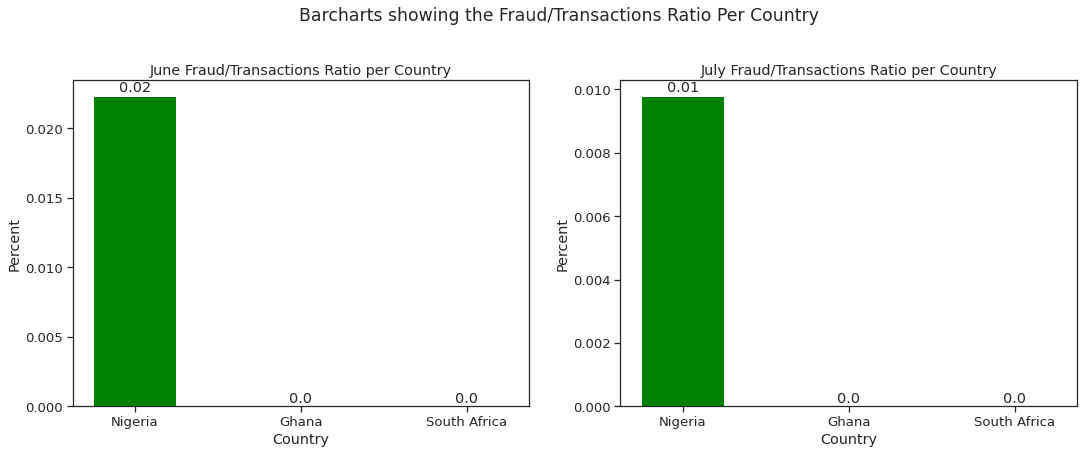

In [33]:
col='Pct'
sup_title = 'Barcharts showing the Fraud/Transactions Ratio Per Country'
titles = ['June Fraud/Transactions Ratio per Country', 'July Fraud/Transactions Ratio per Country']
labels = ['Country', 'Percent']

compare_bar_chart(june_country_fraud_ratio, july_country_fraud_ratio, colours, col)

Usually, only a small portion of transactions are fraudulent per organization.<br>This data shows us that...
1. Only Nigerian transactions recorded fraud
2. For June only 0.02% of transactions were flagged as fraud and only 0.01% in July
3. The data tends to depict that even with more transactions done in July, it had less fraud reports than in June.

**Let's visualize a few descriptive data values we deduced earlier**


In [34]:
indexs = ['max_fraud/Day', 'total_fraud/Month', 'max_otp_fraud/Day', 'ave_fraud_usd/Month','max_fraud_usd/Day']

june_data = [max(june_df.fraud_count), sum(june_df.fraud_count), max(june_df.otp_fraud), \
             june_df.fraud_volume_usd.mean(), max(june_df.fraud_volume_usd)]

july_data = [max(july_df.fraud_count), sum(july_df.fraud_count), max(july_df.otp_fraud), \
             july_df.fraud_volume_usd.mean(), max(july_df.fraud_volume_usd)]

In [35]:
def plot_clustered_bar(indexs, june_data, july_data):
    assert len(indexs) == len(june_data) == len(july_data)

    df = pd.DataFrame([june_data, july_data]).T
    df.index = indexs
    df.columns = ['June', 'July']
    #plt.xkcd()  # For xkcd style plots
    #plt.rcdefaults()  # to stop xkcd plots

    # your colors
    colors = ['#5bc0de', '#d9534f']

    # plot with annotations is probably easier
    p1 = df.plot(kind='bar', 
                 color=colors, 
                 figsize=(size), 
                 rot=0, 
                 ylabel='Count', 
                 title=title)

    plt.show()

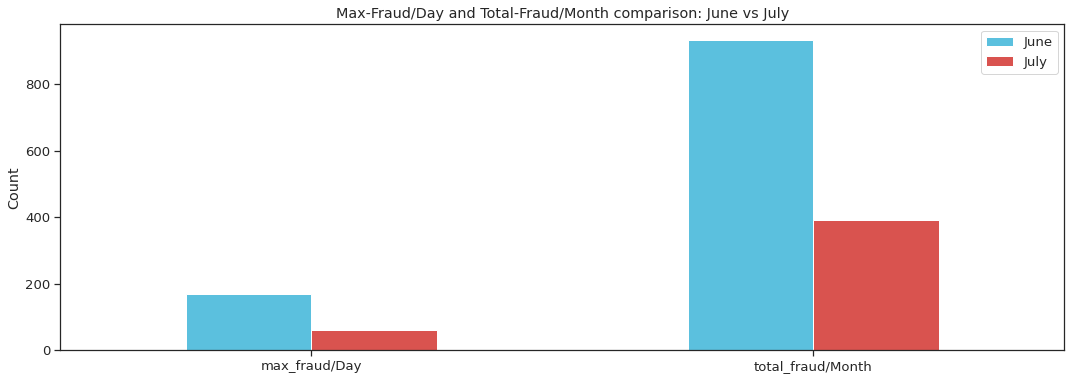

In [36]:
title = 'Max-Fraud/Day and Total-Fraud/Month comparison: June vs July'
plot_clustered_bar(indexs[:2], june_data[:2], july_data[:2])

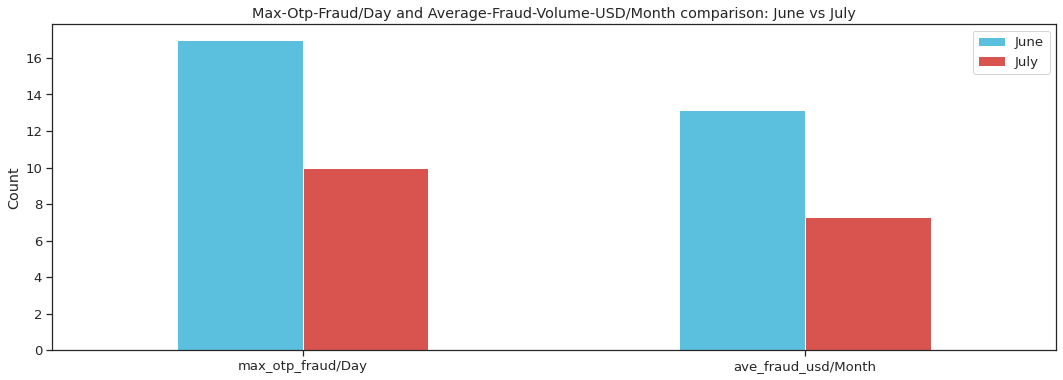

In [37]:
title = 'Max-Otp-Fraud/Day and Average-Fraud-Volume-USD/Month comparison: June vs July'
plot_clustered_bar(indexs[2:4], june_data[2:4], july_data[2:4])

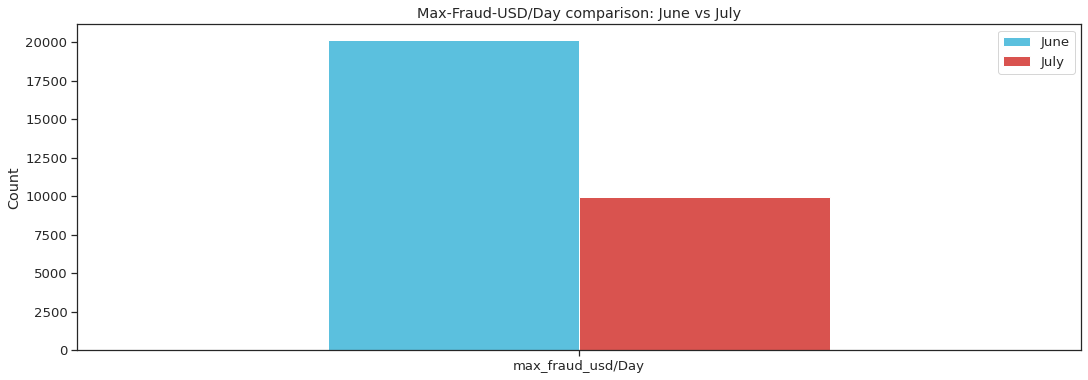

In [38]:
title = 'Max-Fraud-USD/Day comparison: June vs July'
plot_clustered_bar(indexs[4:], june_data[4:], july_data[4:])

# Diagnostic EDA (DA2):

**Diagnostic Analytics (DA2):**<br>
Diagnostic analytics are a deeper look at data to attempt to understand the causes of events and behaviours. It’s used largely to answer the question **[“Why did it happen?”]**, and is characterized by techniques such as : **drill-down** • **data discovery** • **data mining** • **correlations** • **mutual-information**

1. On a weekly basis, what weeks have the most Fraud?
2. Is there a correlation between weekly transactions count and fraud count?
3. Does fraud tend to increase due to social reasons like public holidays?
4. What Industries are most prone to Fraud?
5. What type of Merchants is most prone?
6. What features of the data are strongly related to fraud occurrences? We can try using Mutual-Information and correlation
7. What are the common patterns among merchants who record the most fraud? For example what's the ratio of OTP-fraud to Total fraud for high-risk merchants and others. What's the total and average transactions volume per week for hugh-risk merchants and others? Is there a correlation between fraud-count and transaction-count when compared to high-risk and other merchants? What's the ratio of OTP-fraud to OTP-transactions for high-risk and others? 
8. Can we use clustering algorithms to learn any meaningful patterns or groupings that can help us learn more about the recent fraud spikes?

Asking and answering these questions give us a deeper understanding of the causes or patterns related to the spike in fraud.

### 5. Exploring Mutual-Information (MI) of variables:
Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Mutual information is how many questions you expect the feature to answer about the target. It can help to understand the relative potential of a feature as a predictor of the target, considered by itself. But Mutual Information can't detect interactions between features, is a Univariate metric.

Finally, unlike Correlation that can only detect linear relationships, Mutual Information can detect all kinds and shapes of relations between features and target.

**First, let's combine both datasets**


In [39]:
combined_df = pd.concat([june_df, july_df])
combined_df.shape

(17418, 13)

**Since we joined two Dataframes with each having index from 0 to `len(df)-1`, let's fix the index of the combined-df**

In [41]:
new_index = list(range(len(combined_df)))
combined_df.index = new_index
print('done!')

done!


**Check for possible NaN values after combination**

In [43]:
combined_df.isna().any().sum()

0

In [44]:
combined_df.head()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,0.0,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,0.0,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,0.0,0,1
3,11,SERVICES-PROFESSIONAL,Other,Nigeria,NGN,2021-06-07,card,5,212.335958,0,0.0,0,5
4,15,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-06-07,card,8,550.131234,0,0.0,0,8


**Next, we make a copy of `combined_df` for mutual-information analysis.**

In [45]:
mi_combined = combined_df.copy(deep=True)
print('done!')

done!


In [46]:
# Next, pop the targets

target = mi_combined.pop('fraud_count')

In [47]:
# Next, get separate list for numeric and categoric columns

num_cols = list(mi_combined._get_numeric_data().columns)
cat_cols = list(set(mi_combined.columns) - set(num_cols))
print('done!')

done!


In [48]:
# Next, let's label-encode categorical variables

for colname in cat_cols:
    mi_combined[colname], _ = mi_combined[colname].factorize()
print('done!')

done!


**All categorical features should now have numerical datatypes**

In [50]:
mi_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17418 entries, 0 to 17417
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   merchant_id                  17418 non-null  int64  
 1   merchant_industry            17418 non-null  int64  
 2   merchant_category            17418 non-null  int64  
 3   merchant_country             17418 non-null  int64  
 4   currency                     17418 non-null  int64  
 5   transaction_week_start_date  17418 non-null  int64  
 6   channel                      17418 non-null  int64  
 7   transaction_count            17418 non-null  int64  
 8   transaction_volume_usd       17418 non-null  float64
 9   fraud_volume_usd             17418 non-null  float64
 10  otp_fraud                    17418 non-null  int64  
 11  otp_all_transactions         17418 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 1.7 MB


**Since our target `fraud_count` is a numerical feature, we shall use the mutual_info_regression method...**

In [51]:
# Next, identify discrete features

discrete_features = mi_combined.dtypes == int
print('done')

done


In [52]:
from sklearn.feature_selection import mutual_info_regression as mi

def make_mi_scores(X, y, discreteFeatures):
    mi_scores = mi(X, y, discrete_features=discreteFeatures)
    mi_scores = pd.Series(mi_scores, name='MI_scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

**Now, let's get the Mutual Info scores for the combined data**

In [53]:
mi_scores = make_mi_scores(mi_combined, target, discrete_features)
print('done!')

done!


**Let's see a sample of the top scores**

In [54]:
mi_scores.head()

fraud_volume_usd          0.038169
transaction_volume_usd    0.017231
merchant_id               0.014580
otp_fraud                 0.012047
merchant_industry         0.006285
Name: MI_scores, dtype: float64

In [55]:
def plot_mi_scores(mi_scores):
    scores = mi_scores.sort_values(ascending=True)
    plt.figure(dpi=100, figsize=(8, 5))

    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

    plt.show()

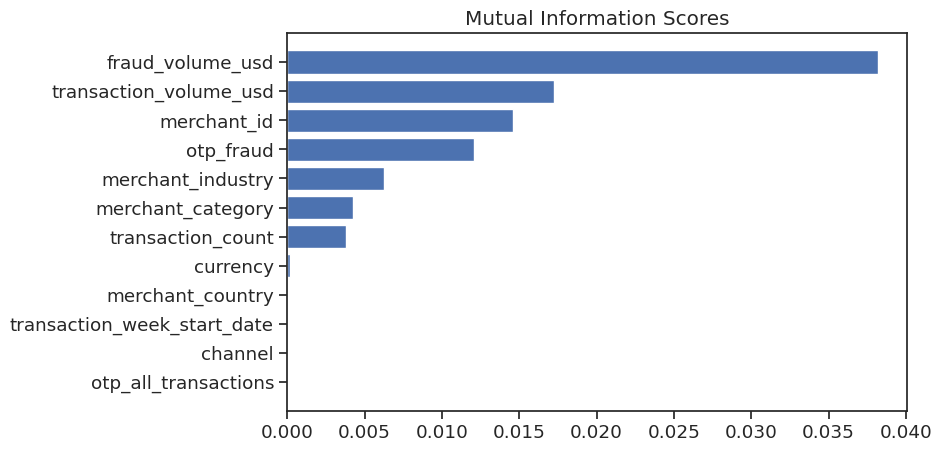

In [56]:
plot_mi_scores(mi_scores)

From the Mutual-Information analysis, we can see the features that are most discriminative to `fraud_count` . Therefore, we can proceed with our analysis focusing on these top features. Let's update the `mi_combined` dataframe to have only these features that tell us something about `fraud-count`.
 

### 6. Selecting Top MI-Scores features:

**Let's select the top features from MI analysis and ofcourse add the `fraud_count` column as our target. This can be used for any machine-learning task.**

In [57]:
# We'd use a threshold of 0.002 based on the MI chart above.
t = 0.002
top_mi = [ind for ind in list(mi_scores.index) if mi_scores[ind] >= t]

In [58]:
# Finally, append target column
top_mi.append('fraud_count')  

In [59]:
top_mi

['fraud_volume_usd',
 'transaction_volume_usd',
 'merchant_id',
 'otp_fraud',
 'merchant_industry',
 'merchant_category',
 'transaction_count',
 'fraud_count']

**Now, we re-create the `mi_combined` df but with only the features from MI-analysis**

In [61]:
# Now select only MI-features
mi_combined = combined_df[top_mi]

print(f'MI-combined shape is: {mi_combined.shape}\n')
mi_combined.head(3)

MI-combined shape is: (17418, 8)



,fraud_volume_usd,transaction_volume_usd,merchant_id,otp_fraud,merchant_industry,merchant_category,transaction_count,fraud_count
0,0.0,231.590551,1,0,GOODS-PHYSICAL,e-Commerce,5,0
1,0.0,210.203412,5,0,SERVICES-LEGAL,Other,2,0
2,0.0,223.097113,9,0,TRAVEL,Travel & Hospitality,4,0


### 7. Analyzing Weekly Fraud Trends:
#### Trying to identify weeks where Fraud is high to check if there are possible social reasons for that.

In [62]:
june_weeks = list(june_df.transaction_week_start_date.unique())
july_weeks = list(july_df.transaction_week_start_date.unique())

In [63]:
print(f'June unique weeks:\n{june_weeks}\nJuly unique weeks:\n{july_weeks}')

June unique weeks:
[numpy.datetime64('2021-06-07T00:00:00.000000000'), numpy.datetime64('2021-06-14T00:00:00.000000000'), numpy.datetime64('2021-06-21T00:00:00.000000000'), numpy.datetime64('2021-06-28T00:00:00.000000000')]
July unique weeks:
[numpy.datetime64('2021-07-05T00:00:00.000000000'), numpy.datetime64('2021-07-12T00:00:00.000000000'), numpy.datetime64('2021-07-19T00:00:00.000000000'), numpy.datetime64('2021-07-26T00:00:00.000000000')]


In [64]:
def get_weekly_fraud_and_transaction_counts(weeks_list, df1, df2, cols):
    """Function to create Series of
        total fraud and transaction counts per-week
    
    @param weeks_list: A list of lists for each month,
    @param df1 and df2: June and July new Dataframes,
    @param cols: List of strings of column names
    @return: Two Series objects
    """
    indexs = []
    fraud_count = []
    trans_count = []
    i, j = 0, 0

    for week in weeks_list:
        if weeks_list.index(week) == 0:
            for wk in week:
                i+=1
                indexs.append('Jun_W'+str(i))
                temp_df = df1[df1[cols[0]] == wk]
                fraud_count.append(sum(temp_df[cols[1]]))
                trans_count.append(sum(temp_df[cols[2]]))
        else:
            for wk in week:
                j+=1
                indexs.append('Jul_W'+str(j))
                temp_df = df2[df2[cols[0]] == wk]
                fraud_count.append(sum(temp_df[cols[1]]))
                trans_count.append(sum(temp_df[cols[2]]))

    serie1 = pd.Series(fraud_count, index=indexs, name='Weekly Fraud Count')
    serie2 = pd.Series(trans_count, index=indexs, name='Weekly Transaction Count')

    return serie1, serie2

In [65]:
weeks_list = [june_weeks, july_weeks]
df1 = june_df
df2 = july_df
cols = ['transaction_week_start_date', 'fraud_count', 'transaction_count']

weekly_fraud_count, weekly_transact_count = get_weekly_fraud_and_transaction_counts(weeks_list, df1, df2, cols)

In [66]:
weekly_fraud_count

Jun_W1    256
Jun_W2    284
Jun_W3    182
Jun_W4    211
Jul_W1    112
Jul_W2    109
Jul_W3     70
Jul_W4    100
Name: Weekly Fraud Count, dtype: int64

In [67]:
weekly_transact_count

Jun_W1     997735
Jun_W2    1064033
Jun_W3    1073565
Jun_W4    1042017
Jul_W1    1030233
Jul_W2     965332
Jul_W3     978273
Jul_W4    1015426
Name: Weekly Transaction Count, dtype: int64

Let's plot the weekly fraud trends...

In [68]:
def plot_weekly_trends(s1, s2):
    """Method for plotting weekly fraud data
    """

    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'bold',
        'size': 16}

    plt.figure(figsize=(24,6))

    plt.subplot(1,2,1)
    plt.plot(s1)
    plt.xlabel('Week', fontdict=font)
    plt.ylabel('Count', fontdict=font)
    font['size'] = 20
    plt.title(s1.name, fontdict=font)

    plt.subplot(1,2,2)
    plt.bar(x=s2.index, height=list(s2))
    plt.title(s2.name, fontdict=font)
    font['size'] = 16
    plt.xlabel('Week', fontdict=font)
    plt.ylabel('Count', fontdict=font)

    plt.show()

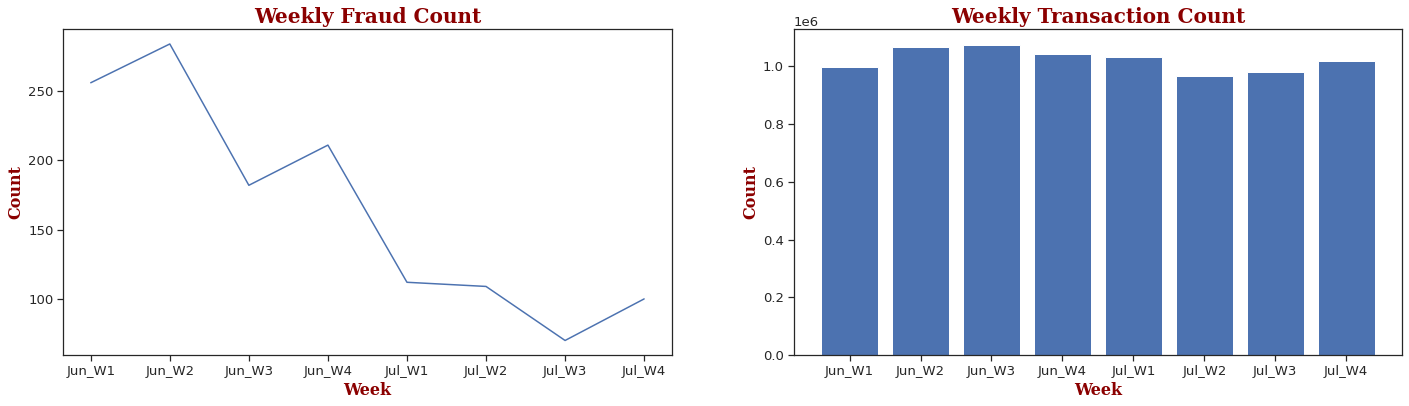

In [69]:
s1 = weekly_fraud_count
s2 = weekly_transact_count

plot_weekly_trends(s1, s2)

From the weekly fraud trend data, we can see that generally, fraud is trending downward. This does not mean it may not trend upward in the future, though, as can be seen in the rise in last week of July.

* Fraud starts high at about 250 for June-Wk-1
* It increases to about 280 for June-Wk-2
* Then it drops to about 180 in June-Wk-3
* Then it rises to about 210 in June-Wk-4
* And just keeps dropping weekly in July, lowest in July-Wk-3
* Starts rising again in July-Wk-4

While the weekly transactions count remain fairly constant between 970k and 1.07 million. Therefore, the data does not support the hypothesis that as fewer transactions are done, fewer fraud tends to be done. This is because the rate of fraud tends to decrease week by week, even though fairly same transactions are done. In otherwords, there's a weak correlation if any between weekly fraud count and weekly transactions count.

Although correlation does not imply cauation, we can see that:-   
* June 14th which marks the start of June-Wk-2 is a national holiday called **democracy-day** in Nigeria
* June 20th is Father's day
* June 23rd is also a regional holiday in Ebonyi State
* Tuesday July 20th and Wednesday July 21st are also public holidays called **id-el-kabir**

[source1](https://www.timeanddate.com/holidays/nigeria/), [source2](https://www.officeholidays.com/countries/nigeria/2021)

### 8. Drilling down on Fraudulent transactions data:

In [72]:
june_fraud_specific = june_df[june_df.fraud_count > 0]
print(f'June Fraud-Specific data shape is: {june_fraud_specific.shape}\n')

june_fraud_specific.head(3)

June Fraud-Specific data shape is: (61, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
7,31,SAVINGS,Financial Services,Nigeria,NGN,2021-06-07,card,161803,1.840269e+06,2,0.787402,1,2247
26,114,CORPORATE,Other,Nigeria,NGN,2021-06-07,card,11317,2.271184e+05,1,5.511811,0,3063
34,147,BETTING,Betting,Nigeria,NGN,2021-06-07,card,16415,3.563845e+05,4,539.212598,3,2896


In [73]:
july_fraud_specific = july_df[july_df.fraud_count > 0]
print(f'July Fraud-Specific data shape is: {july_fraud_specific.shape}\n')

july_fraud_specific.head(3)

July Fraud-Specific data shape is: (51, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
9,30,SAVINGS,Financial Services,Nigeria,NGN,2021-07-05,card,165099,1.822132e+06,10,1443.832021,1,2294
36,145,LENDING,Financial Services,Nigeria,NGN,2021-07-05,card,16172,3.501336e+05,1,2.650919,0,2786
128,486,BETTING,Betting,Nigeria,NGN,2021-07-05,card,232184,1.784707e+06,62,8424.934383,6,58841


**Let's see the distribution of fraud across `merchant_category` for June and July**

In [74]:
def selection(df, arr, empty_arr):
    """helper method for function below
    """
    for item in arr:
        temp = df[df[var] == item]
        empty_arr.append(sum(temp['fraud_count']))


def get_fraud_distribution_per_var(df1, df2, var, names, s=selection):
    """Function to derive fraud distribution per variable
        for both June and July datasets.

    @param df1 and df2; June and July Dataframes
    @param var: The specific categorical variable to split over
    @param names: A list of string titles for each Series
    @return: Two Series sorted descending
    """
    unique1 = list(df1[var].unique())
    unique2 = list(df2[var].unique())
    s1_list = []
    s2_list = []

    s(df1, unique1, s1_list)
    s(df2, unique2, s2_list)

    s1 = pd.Series(s1_list, index=unique1, name=names[0])
    s2 = pd.Series(s2_list, index=unique2, name=names[1])
    s1.sort_values(ascending=False, inplace=True)
    s2.sort_values(ascending=False, inplace=True)

    # compute percentages
    s1 = (s1 / sum(s1)) * 100
    s2 = (s2 / sum(s2)) * 100

    return s1, s2

In [75]:
df1 = june_fraud_specific
df2 = july_fraud_specific
var = 'merchant_category'
names = ['Merchant-Category Fraud: June', 'Merchant-Category Fraud: July']

june_merchant_cat_fraud, july_merchant_cat_fraud = get_fraud_distribution_per_var(df1, df2, var, names)
print('done!')

done!


In [76]:
june_merchant_cat_fraud

Betting                  80.814577
Financial Services       17.363344
Digital Services          0.643087
Other                     0.428725
Utilities                 0.321543
Media & Entertainment     0.214362
e-Commerce                0.107181
Education                 0.107181
Name: Merchant-Category Fraud: June, dtype: float64

In [77]:
july_merchant_cat_fraud

Financial Services      52.429668
Betting                 42.710997
e-Commerce               2.301790
Education                1.023018
Utilities                0.767263
Other                    0.511509
Travel & Hospitality     0.255754
Name: Merchant-Category Fraud: July, dtype: float64

**Let's visualize the top 5 merchant categories for fraudulent transactions**

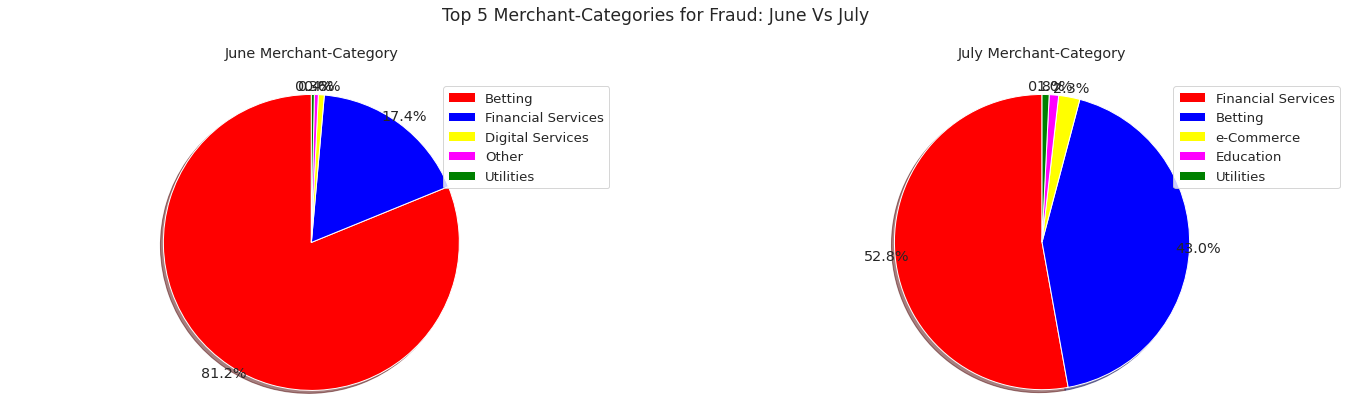

In [78]:
sup_title = 'Top 5 Merchant-Categories for Fraud: June Vs July'
titles = ['June Merchant-Category', 'July Merchant-Category']
s1 = june_merchant_cat_fraud[:5]
s2 = july_merchant_cat_fraud[:5]
colours = ['red', 'blue', 'yellow', 'magenta', 'green']
size = (24, 6)

compare_pie_chart(sup_title, titles, s1, s2, size, colours)

We can see that two merchant-categories make up more than 98% of total fraud. These are
1. Betting
2. Financial services

**Let's see the distribution of fraud across `merchant_industry` for June and July**

In [79]:
df1 = june_fraud_specific
df2 = july_fraud_specific
var = 'merchant_industry'
names = ['Merchant-Industry Fraud: June', 'Merchant-Industry Fraud: July']

june_merchant_ind_fraud, july_merchant_ind_fraud = get_fraud_distribution_per_var(df1, df2, var, names)
print('done!')

done!


In [80]:
june_merchant_ind_fraud

BETTING                 80.814577
LENDING                 16.077170
COOPERATIVES             0.857449
SERVICES-DIGITAL         0.643087
INTERNET                 0.321543
SAVINGS                  0.321543
NGO                      0.214362
SERVICES-PHYSICAL        0.107181
GOODS-PHYSICAL           0.107181
EDUCATION-VOCATIONAL     0.107181
RELIGIOUS                0.107181
REALESTATE               0.107181
REMITTANCE               0.107181
CORPORATE                0.107181
Name: Merchant-Industry Fraud: June, dtype: float64

In [81]:
july_merchant_ind_fraud

BETTING                  42.710997
LENDING                  40.153453
SAVINGS                   8.439898
GOODS-PHYSICAL            2.301790
INVESTMENT                2.301790
EDUCATION-SECONDARY       0.767263
REMITTANCE                0.511509
PSSP                      0.511509
TELECOMS                  0.511509
ASSOCIATION               0.255754
WALLETS                   0.255754
ELECTRICITY               0.255754
TRAVEL                    0.255754
COOPERATIVES              0.255754
EDUCATION-TERTIARY        0.255754
SERVICES-PROFESSIONAL     0.255754
Name: Merchant-Industry Fraud: July, dtype: float64

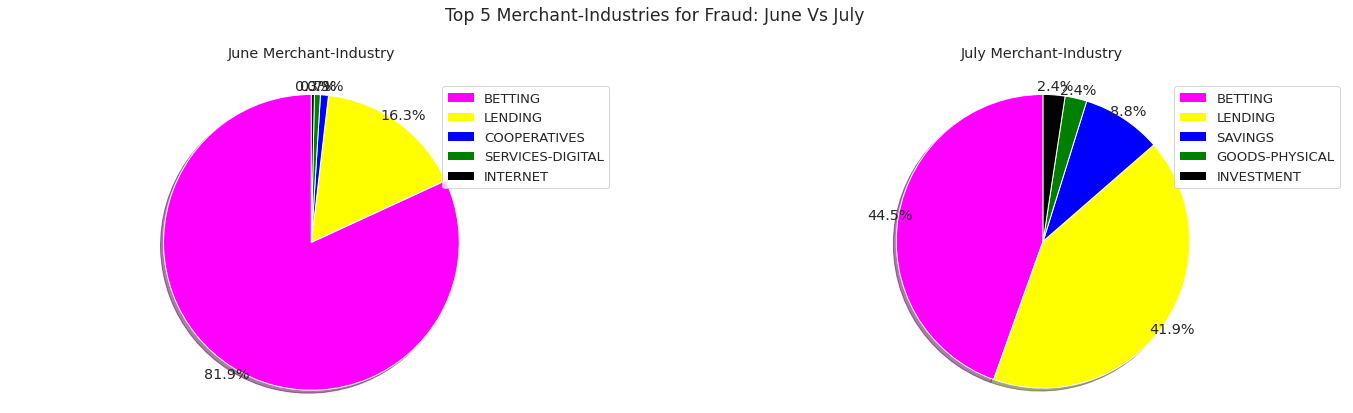

In [82]:
sup_title = 'Top 5 Merchant-Industries for Fraud: June Vs July'
titles = ['June Merchant-Industry', 'July Merchant-Industry']
s1 = june_merchant_ind_fraud[:5]
s2 = july_merchant_ind_fraud[:5]
colours = ['magenta', 'yellow', 'blue', 'green', 'black']
size = (24, 6)

compare_pie_chart(sup_title, titles, s1, s2, size, colours)

From the two sets of Piecharts above, we can surmise that...<br>
Merchants in the **Betting** and **Financial Services** category, who operate within the **Betting** and **Lending** industries recorded more than 98% of total frauds across merchant-categories and more than 96% of total fraud across merchant-industries, for the months of June and July 2021.

**The next step is to identify these merchants...**

So, we want to select merchants in the Betting and Financial-Services(FS) categories that operate within the Betting and Lending industries.

In [83]:
# First, we select Merchants whose category is either FS or Betting
top_concern = combined_df[(combined_df.merchant_category == 'Betting') \
                                    | (combined_df.merchant_category == 'Financial Services')]

# Then from these, we select those whose industries are BETTING or LENDING
top_concern = top_concern[(top_concern.merchant_industry == 'BETTING') \
                                              | (top_concern.merchant_industry == 'LENDING')]

# We do it this way, just incase BETTING and LENDING industries also exist in 
# other marchant-categories aside from Betting and Financial-Services.

print(f'Top-Concern-Merchants shape is: {top_concern.shape}\n', end=' ')
top_concern.head()

Top-Concern-Merchants shape is: (1521, 13)
 

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
27,118,LENDING,Financial Services,Nigeria,NGN,2021-06-07,card,2511,30218.315853,0,0.000000,0,579
29,126,BETTING,Betting,Nigeria,NGN,2021-06-07,card,2,19.685039,0,0.000000,0,1
34,147,BETTING,Betting,Nigeria,NGN,2021-06-07,card,16415,356384.474199,4,539.212598,3,2896
37,158,LENDING,Financial Services,Nigeria,NGN,2021-06-07,card,1,0.026247,0,0.000000,0,1
50,216,BETTING,Betting,Nigeria,NGN,2021-06-07,card,81,1005.225696,0,0.000000,0,58


**Since we've identified them, let's also separate the others**

In [84]:
others_index = list(set(list(combined_df.index)) - set(list(top_concern.index)))
(len(others_index) + len(top_concern.index)) == len(combined_df.index)

True

In [85]:
others = combined_df.iloc[others_index, :]
print(len(others_index) == len(others))
print(f'others shape: {others.shape}\n')
others.head(3)

True
others shape: (15897, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,0.0,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,0.0,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,0.0,0,1
3,11,SERVICES-PROFESSIONAL,Other,Nigeria,NGN,2021-06-07,card,5,212.335958,0,0.0,0,5
4,15,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-06-07,card,8,550.131234,0,0.0,0,8


### 9. Finding Distinct Patterns of High-Risk Merchants

**Let's see the descriptive statistics for these `top-concern` merchants**

In [86]:
# Let's see for Categorical Variables of top-concern merchants

top_concern.describe(include='object').T

,count,unique,top,freq
merchant_industry,1521,2,LENDING,973
merchant_category,1521,2,Financial Services,973
merchant_country,1521,1,Nigeria,1521
currency,1521,1,NGN,1521
channel,1521,1,card,1521


In [87]:
# Let's see for Categorical Variables of other merchants

others.describe(include='object').T

,count,unique,top,freq
merchant_industry,15897,61,GOODS-PHYSICAL,2714
merchant_category,15897,11,Digital Services,3035
merchant_country,15897,3,Nigeria,15840
currency,15897,4,NGN,15763
channel,15897,1,card,15897


In [88]:
# Let's see for Numerical Variables of top-concern merchants

top_concern.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_id,1521.0,4529.500329,2440.657734,65.000000,2520.000000,4571.000000,6835.000000,8.776000e+03
transaction_count,1521.0,3538.559500,23489.974503,1.000000,4.000000,26.000000,379.000000,2.758660e+05
transaction_volume_usd,1521.0,32272.061795,159843.601025,0.000131,19.181102,254.397559,3792.478163,2.271810e+06
fraud_count,1521.0,0.807364,7.982570,0.000000,0.000000,0.000000,0.000000,1.700000e+02
fraud_volume_usd,1521.0,102.467606,1082.253882,0.000000,0.000000,0.000000,0.000000,2.017848e+04
otp_fraud,1521.0,0.077581,0.733971,0.000000,0.000000,0.000000,0.000000,1.700000e+01
otp_all_transactions,1521.0,994.812623,9014.567615,0.000000,2.000000,17.000000,230.000000,2.015910e+05


In [89]:
# Let's see for Numerical Variables of other merchants

others.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_id,15897.0,4337.852740,2521.710303,1.000000,2156.000000,4340.000000,6489.000000,8.809000e+03
transaction_count,15897.0,175.156633,3775.687452,1.000000,1.000000,2.000000,9.000000,1.716440e+05
transaction_volume_usd,15897.0,4281.138742,52743.628819,0.000026,8.764698,39.370079,194.225722,2.444412e+06
fraud_count,15897.0,0.006039,0.192888,0.000000,0.000000,0.000000,0.000000,1.500000e+01
fraud_volume_usd,15897.0,1.374160,71.472388,0.000000,0.000000,0.000000,0.000000,6.430446e+03
otp_fraud,15897.0,0.001447,0.073966,0.000000,0.000000,0.000000,0.000000,8.000000e+00
otp_all_transactions,15897.0,35.779329,237.725621,0.000000,1.000000,2.000000,7.000000,6.980000e+03


From the decribtive stats above, we can see that...
* High-Risk merchants on average performed 3538 transactions within the review period, whie other merchants did an average of 175 transactions.
* High-Risk merchants in the Betting and Lending business did an average of `$32k` USD for the period. Others did an average of `$4.2k` USD.

**Let's apply some data visualizations, see if we can spot patterns or distinct behaviors as we compare high-risk merchants to others**

We can check...
* The weekly transaction volume for `top` and `others`
* The average transaction volume per week for `top` and `others`
* The ratio of OTP fraud to OTP_transactions for `top` and `others`